# COVID EDA STAT 431

by Stan Lee and Jay Lee





Import Spark

In [1]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext(appName="YourTest", master="local[*]")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:

timeseries_confirmed = pd.read_csv("/content/drive/MyDrive/time_series_covid19_confirmed_global.csv")
timeseries_death = pd.read_csv("/content/drive/MyDrive/time_series_covid19_deaths_global.csv")
timeseries_recovered = pd.read_csv("/content/drive/MyDrive/time_series_covid19_recovered_global.csv")

# data_india = pd.read_csv("/content/drive/MyDrive/covid india/covid_19_india.csv")
# data_india_state = pd.read_csv("/content/drive/MyDrive/covid india/StatewiseTestingDetails.csv")

data_usa_state = pd.read_csv("/content/drive/MyDrive/us_states_covid19_daily.csv")
data_usa = pd.read_csv("/content/drive/MyDrive/us_covid19_daily.csv")
data_usa_county = pd.read_csv("/content/drive/MyDrive/us_counties_covid19_daily.csv")

# Questions to ask, using the timeseries data of confirmed and death of global data, when can we expect an end of cases, or peak of cases?
# After looking at the trend, how is USA doing compared to India? and other countries?

# 참조할 노트북: https://github.com/corazzon/COVID-19-eda/blob/master/02-COVID-19-patient-output.ipynb
#               https://github.com/corazzon/COVID-19-eda/blob/master/01-COVID-19-ko-wikipedia-eda-output.ipynb
#               https://www.kaggle.com/surajkumar88/covid19-case-study-analysis-viz-predictions

# Dataset is now stored in a Pandas Dataframe

### Data Import Process

### Analyze

In [9]:
timeseries_death = timeseries_death.drop(["Province/State", "Lat","Long"], axis=1)

In [10]:
timeseries_confirmed = timeseries_confirmed.drop(["Province/State", "Lat","Long"], axis=1)

In [11]:
timeseries_recovered = timeseries_recovered.drop(["Province/State", "Lat","Long"], axis=1)

In [12]:
confirmed_group_df = timeseries_confirmed.groupby(by='Country/Region',as_index=False).sum()
deaths_group_df = timeseries_death.groupby(by='Country/Region',as_index=False).sum()
recoveries_group_df = timeseries_recovered.groupby(by='Country/Region',as_index=False).sum()

active_group_df = pd.DataFrame(columns=[confirmed_group_df.columns])
active_group_df = deaths_group_df.copy()
for i in range(confirmed_group_df.shape[0]):
    for j in range(3, confirmed_group_df.shape[1]):
        active_group_df.iloc[i,j] = confirmed_group_df.iloc[i,j]-(recoveries_group_df.iloc[i,j]+deaths_group_df.iloc[i,j])

In [13]:
data = pd.DataFrame(columns=['Dates','Confirmed','Deaths','Recovered','Active'])
data['Dates'] = timeseries_confirmed.columns[4:]

data['Confirmed'] = data['Dates'].apply(lambda x: timeseries_confirmed[x].sum())
data['Deaths'] = data['Dates'].apply(lambda x: timeseries_death[x].sum())
data['Recovered'] = data['Dates'].apply(lambda x: timeseries_recovered[x].sum())
data.reset_index(drop=False, inplace=True)
data['Active'] = data['index'].apply(lambda x: (data['Confirmed'][x]-(data['Deaths'][x]+data['Recovered'][x])))
data['DeathRatio'] = data['index'].apply(lambda x: (data['Deaths'][x] / data['Confirmed'][x]))
data['ActiveRatio'] = data['index'].apply(lambda x: (data['Active'][x] / data['Confirmed'][x]))
data['RecoveredRatio'] = data['index'].apply(lambda x: (data['Recovered'][x] / data['Confirmed'][x]))
data.head()

,index,Dates,Confirmed,Deaths,Recovered,Active,DeathRatio,ActiveRatio,RecoveredRatio
0,0,1/25/20,1434,42,39,1353,0.029289,0.943515,0.027197
1,1,1/26/20,2118,56,52,2010,0.026440,0.949008,0.024551
2,2,1/27/20,2927,82,61,2784,0.028015,0.951145,0.020840
3,3,1/28/20,5578,131,107,5340,0.023485,0.957332,0.019183
4,4,1/29/20,6167,133,126,5908,0.021566,0.958002,0.020431


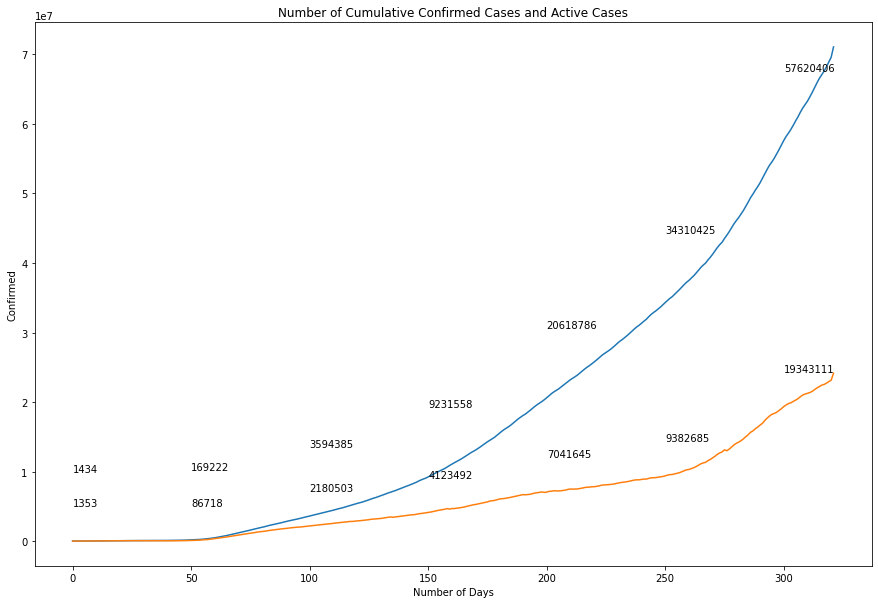

In [14]:
plt.figure(figsize=(15, 10))
#plt.xticks(rotation=30)
#g = sns.pointplot(data=country_data_filtered, x="Country/Region", y="12/4/20")
g = sns.lineplot(data=data, x="index", y="Confirmed")
g = sns.lineplot(data=data, x="index", y="Active")
plt.xlabel('Number of Days')
plt.title("Number of Cumulative Confirmed Cases and Active Cases")

for i, cnt in enumerate(data["Active"]):
    if cnt > 0 and i%50==0:
        g.text(x=i, y=cnt+5000000, s=round(cnt))

for i, cnt in enumerate(data["Confirmed"]):
    if cnt > 0 and i%50==0:
        g.text(x=i, y=cnt+10000000, s=round(cnt))

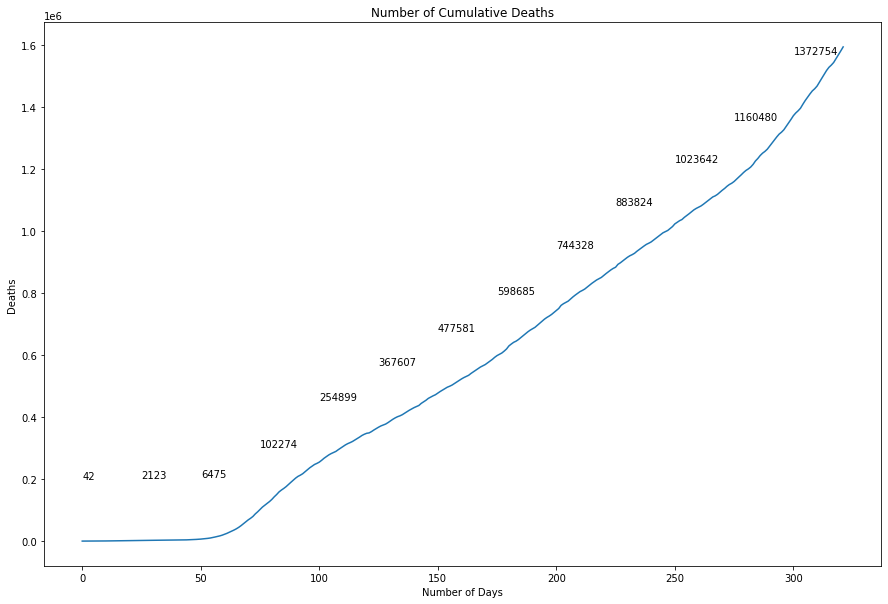

In [15]:
plt.figure(figsize=(15, 10))
g = sns.lineplot(data=data, x="index", y="Deaths")
plt.xlabel('Number of Days')
plt.title("Number of Cumulative Deaths")

for i, cnt in enumerate(data["Deaths"]):
    if cnt > 0 and i%25==0:
        g.text(x=i, y=cnt+200000, s=round(cnt))

Text(0.5, 1.0, 'Death Ratio + Active Ratio + Recovered Ratio')

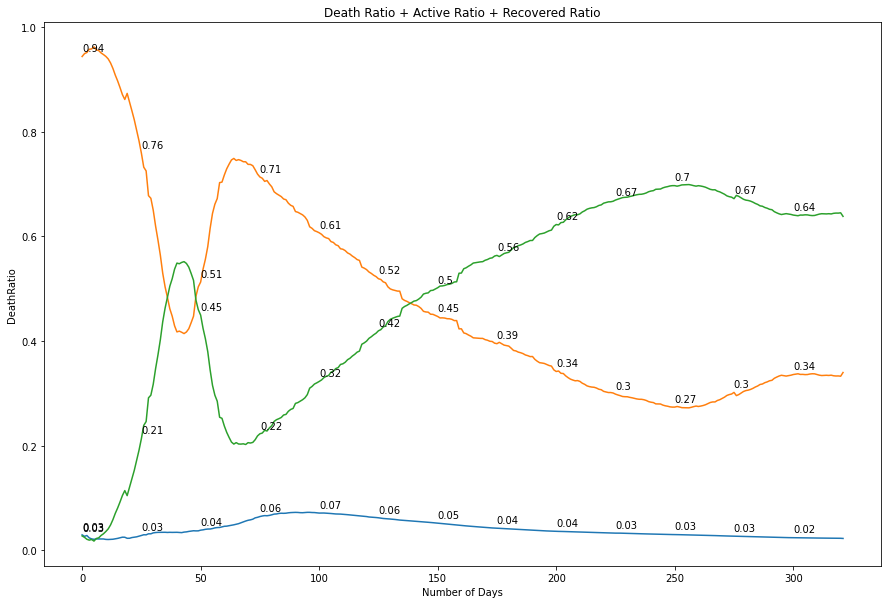

In [16]:
plt.figure(figsize=(15, 10))
g = sns.lineplot(data=data, x="index", y="DeathRatio")
g = sns.lineplot(data=data, x="index", y="ActiveRatio")
g = sns.lineplot(data=data, x="index", y="RecoveredRatio")
for i, cnt in enumerate(data["DeathRatio"]):
    if cnt > 0 and i%25==0:
        g.text(x=i-0.1, y=cnt+0.01, s=round(cnt,2))

for i, cnt in enumerate(data["ActiveRatio"]):
    if cnt > 0 and i%25==0:
        g.text(x=i-0.1, y=cnt+0.01, s=round(cnt,2))

for i, cnt in enumerate(data["RecoveredRatio"]):
    if cnt > 0 and i%25==0:
        g.text(x=i, y=cnt+0.01, s=round(cnt,2))

plt.xlabel('Number of Days')
plt.title("Death Ratio + Active Ratio + Recovered Ratio")

In [17]:
def createCountryData(df):
  listofindex = []
  for i in range(len(df)):
    if df["12/4/20"][i] > 1500000:
      listofindex.append(i)
    else:
      pass
  return listofindex


In [18]:
def createCountryDataDeath(df):
  listofindex = []
  for i in range(len(df)):
    if df["12/4/20"][i] > 500000:
      listofindex.append(i)
    else:
      pass
  return listofindex

In [19]:
index = createCountryData(timeseries_confirmed)

In [20]:
country_data_filtered = timeseries_confirmed.T[index].T

In [21]:
country_data_death_filtered = timeseries_death.T[index].T

Text(0.5, 1.0, 'Cumulative Cases @ December 11, 2020')

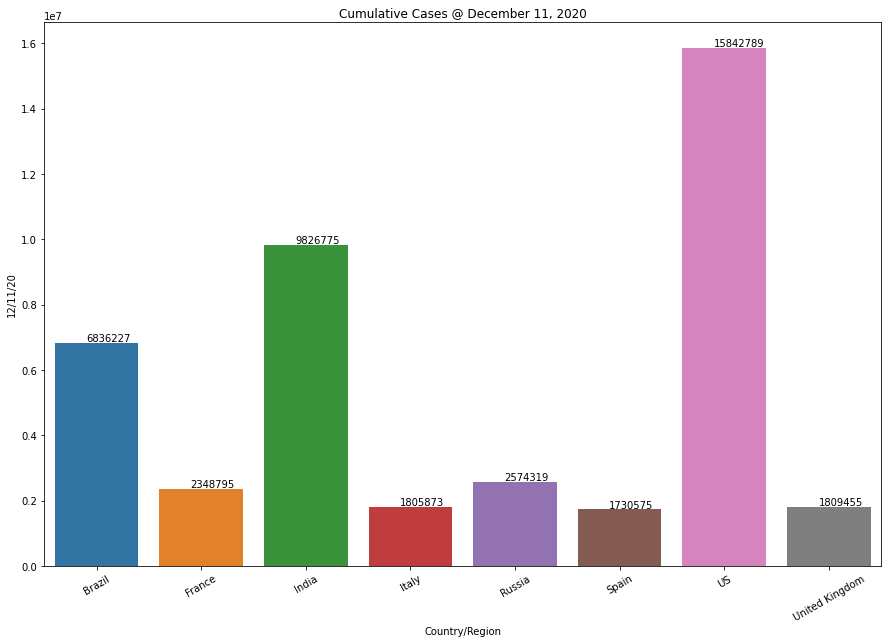

In [22]:
plt.figure(figsize=(15, 10))
plt.xticks(rotation=30)
g = sns.barplot(data=country_data_filtered, x="Country/Region", y="12/11/20")
for i, cnt in enumerate(country_data_filtered["12/11/20"]):
    if cnt > 100:
        g.text(x=i-0.1, y=cnt+50000, s=round(cnt))

plt.title("Cumulative Cases @ December 11, 2020")

Text(0.5, 1.0, 'Cumulative Deaths @ December 11, 2020')

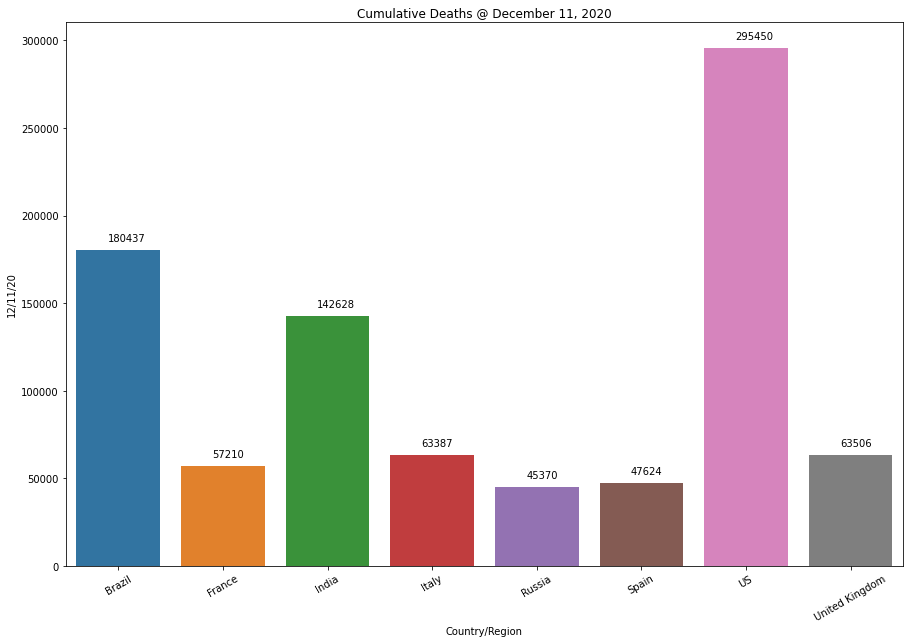

In [23]:
plt.figure(figsize=(15, 10))
plt.xticks(rotation=30)
#g = sns.pointplot(data=country_data_death_filtered, x="Country/Region", y="12/11/20")
g = sns.barplot(data=country_data_death_filtered, x="Country/Region", y="12/11/20")
for i, cnt in enumerate(country_data_death_filtered["12/11/20"]):
    if cnt > 100:
        g.text(x=i-0.1, y=cnt+5000, s=round(cnt))

plt.title("Cumulative Deaths @ December 11, 2020")

## New Section

Potential analysis-

1. US Cases and deaths after and before quarantine
2. US Cases and deaths by states
3. rates of population versus cases in each states to figure out the top 5 states with the highest rates

## Plot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


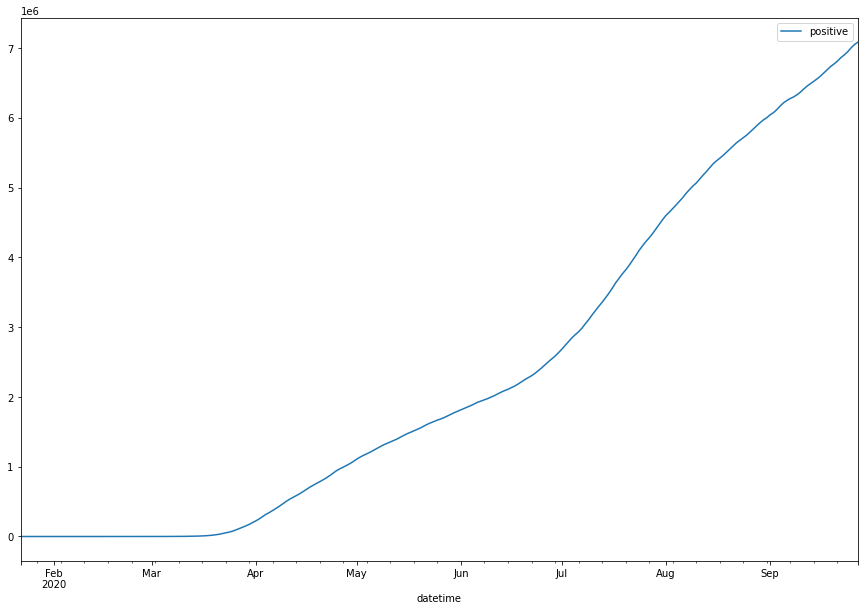

In [24]:
usa = data_usa[['date','positive']]

usa['datetime'] = usa['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))


usa.plot(x='datetime',y='positive',figsize=(15,10))


In [25]:
data_usa_state.head()

,date,state,positive,negative,pending,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,deathConfirmed,deathProbable,totalTestEncountersViral,totalTestsPeopleViral,totalTestsAntibody,positiveTestsAntibody,negativeTestsAntibody,totalTestsPeopleAntibody,positiveTestsPeopleAntibody,negativeTestsPeopleAntibody,totalTestsPeopleAntigen,positiveTestsPeopleAntigen,totalTestsAntigen,positiveTestsAntigen,fips,positiveIncrease,negativeIncrease,total,totalTestResultsSource,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20200927,AK,8431.0,434554.0,NaN,442869.0,43.0,NaN,NaN,NaN,14.0,NaN,3502.0,A,9/27/2020 03:59,2020-09-27T03:59:00Z,09/26 23:59,56.0,NaN,2020-09-27T03:59:00Z,442869.0,7411.0,435171.0,8431.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,116,0,442985,posNeg,0,442985,4,0,0e31d4ec1f53f08bad068d6295b2cede60fd0b6b,0,0,0,0,0,NaN
1,20200927,AL,152321.0,975685.0,NaN,1111239.0,741.0,16852.0,NaN,1791.0,NaN,1007.0,64583.0,A,9/27/2020 11:00,2020-09-27T11:00:00Z,09/27 07:00,2501.0,16852.0,2020-09-27T11:00:00Z,1111239.0,NaN,NaN,135554.0,2364.0,137.0,NaN,NaN,NaN,NaN,NaN,58032.0,NaN,NaN,NaN,NaN,NaN,NaN,1,730,5637,1128006,posNeg,6307,1128006,0,0,9caeb5e62982ebd77096043a91075390c6e5e7f3,0,0,0,0,0,NaN
2,20200927,AR,81242.0,861892.0,NaN,940627.0,452.0,5235.0,211.0,NaN,86.0,661.0,72602.0,A+,9/27/2020 00:00,2020-09-27T00:00:00Z,09/26 20:00,1308.0,5235.0,2020-09-27T00:00:00Z,940627.0,NaN,861892.0,78735.0,1160.0,148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10266.0,2710.0,21856.0,3300.0,5,487,6257,943134,posNeg,6732,943134,23,33,1383566a86c446fbab10499d61477c713a6d853a,0,0,0,0,0,NaN
3,20200927,AS,0.0,1571.0,NaN,1571.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,9/1/2020 00:00,2020-09-01T00:00:00Z,08/31 20:00,0.0,NaN,2020-09-01T00:00:00Z,1571.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,0,0,1571,posNeg,0,1571,0,0,2153f0c1fadb4040be5775010cabe901a40e4ee7,0,0,0,0,0,NaN
4,20200927,AZ,217237.0,1230608.0,NaN,1443323.0,483.0,22015.0,116.0,NaN,59.0,NaN,34872.0,A+,9/27/2020 00:00,2020-09-27T00:00:00Z,09/26 20:00,5623.0,22015.0,2020-09-27T00:00:00Z,NaN,NaN,NaN,212715.0,5356.0,267.0,NaN,1443323.0,291300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,411,8757,1447845,posNeg,9096,1447845,1,10,d32d753876065a384f715e9774370ea8d39803df,0,0,0,0,0,NaN


Text(0.5, 1.0, 'Cumulative positive cases by states of US @ September 9th, 2020')

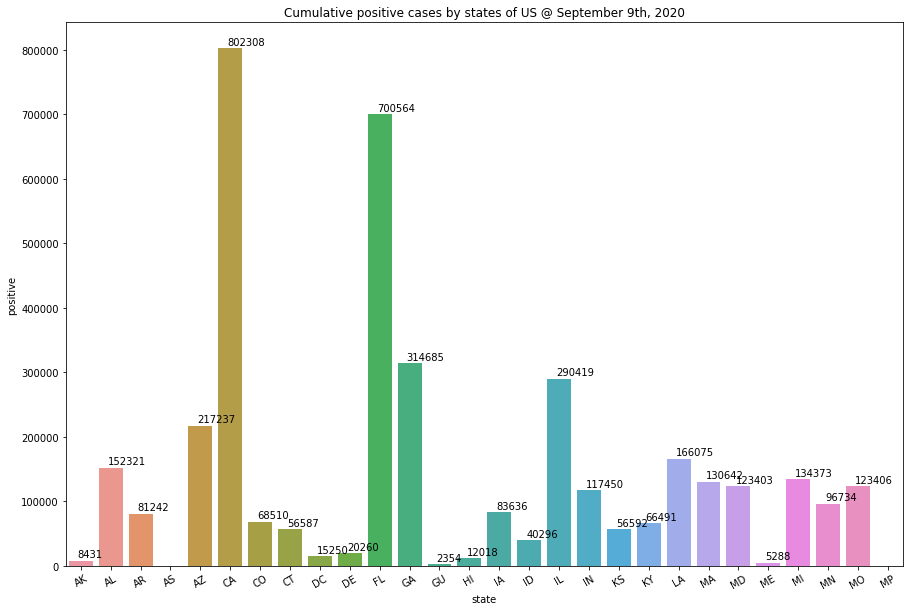

In [26]:
recent_data_state = data_usa_state[(data_usa_state['date'] == 20200927)]


## first 28 states in US
first_positive_state = recent_data_state[['state','positive']].head(28) ## 56 states

## second 28 states in US
second_positive_state = recent_data_state[['state','positive']].tail(28)

plt.figure(figsize=(15, 10))
plt.xticks(rotation=30)
g = sns.barplot(data=first_positive_state, x="state", y="positive")
for i, cnt in enumerate(first_positive_state["positive"]):
    if cnt > 100:
        g.text(x=i-0.1, y=cnt+5000, s=round(cnt))

plt.title("Cumulative positive cases by states of US @ September 9th, 2020")

Text(0.5, 1.0, 'Cumulative positive cases by states of US @ September 9th, 2020')

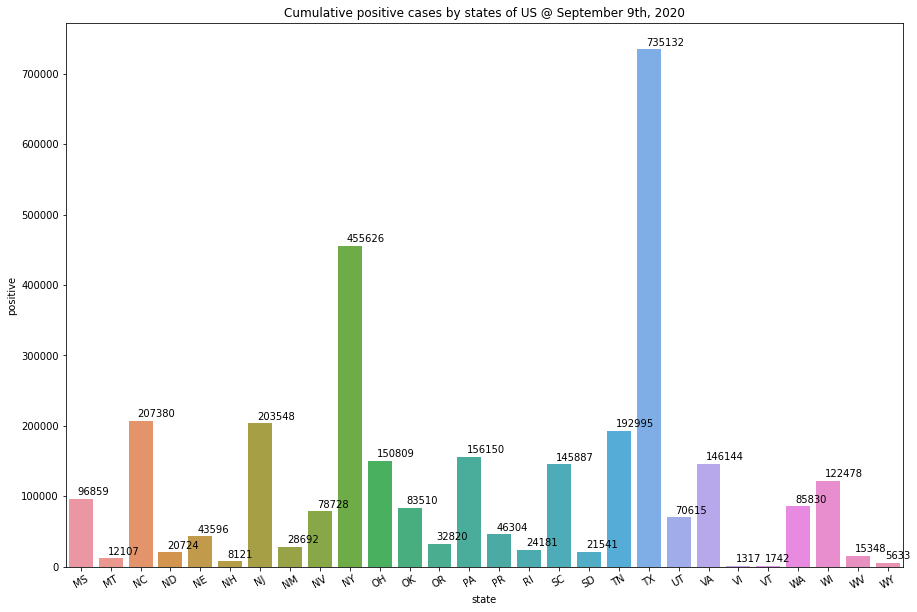

In [27]:
plt.figure(figsize=(15, 10))
plt.xticks(rotation=30)
g = sns.barplot(data=second_positive_state, x="state", y="positive")
for i, cnt in enumerate(second_positive_state["positive"]):
    if cnt > 100:
        g.text(x=i-0.1, y=cnt+5000, s=round(cnt))

plt.title("Cumulative positive cases by states of US @ September 9th, 2020")

Above graph illustrates that California, Taxas, and Florida are top 3 states with highest number of people who are tested positive from COVID-19 test. First, we will discover the trend of the number of COVID-19 positive patients in time stamp of April 2020, to September 2020.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Text(0.5, 1.0, 'Trend of cumulative positive cases of top 3 states')

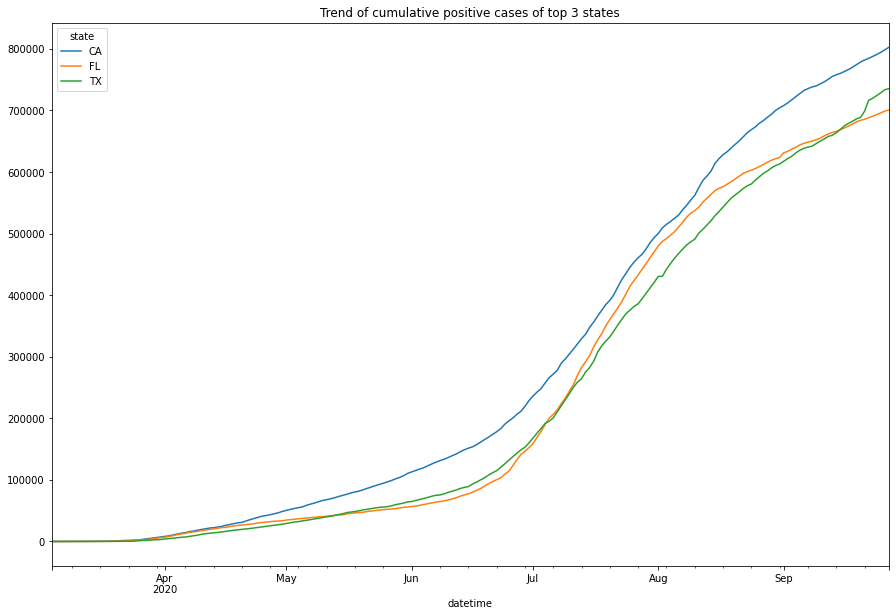

In [28]:
top_3 = data_usa_state[data_usa_state['state'].isin(['TX','CA','FL'])]



top_3['datetime'] = top_3['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

top_3.datetime = pd.to_datetime(top_3.datetime)

positive_top_3 = top_3[['datetime','positive','state']]

positive_top_3 = positive_top_3.pivot(index = 'datetime', columns = 'state', values = 'positive')

positive_top_3
positive_top_3.plot(figsize=(15,10))

plt.title("Trend of cumulative positive cases of top 3 states")

According to the plot above, we see the increasing trend of the positive cases for each states. The slope of the plot seems to be very stiff from July to August, meaning that compare to other periods, exceptional number of positive cases were found in top three states during July to August.

Now let's check for the death rate in September 9th, 2020 for states in US:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Text(0.5, 1.0, 'Death rate by states of US @ September 9th, 2020')

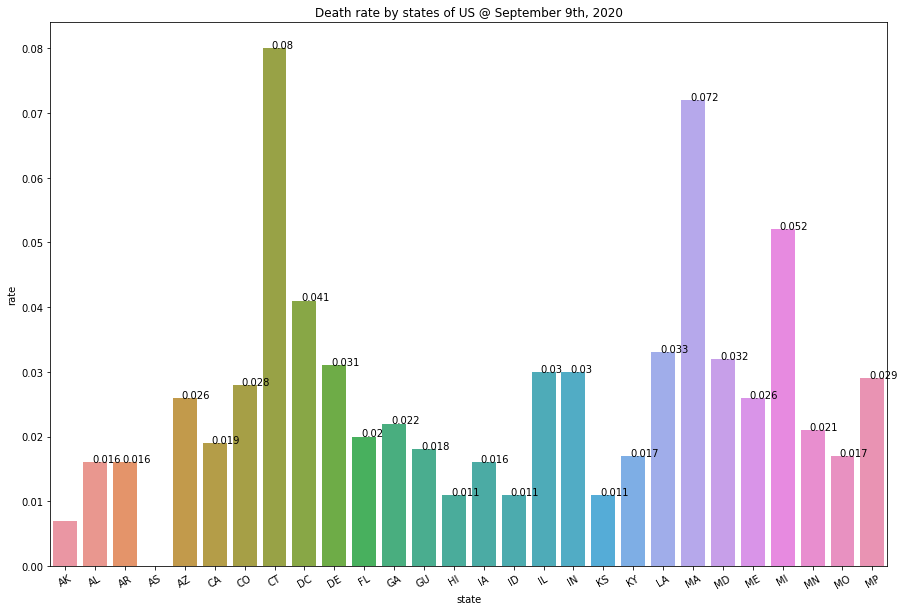

In [29]:
death_rate = data_usa_state[(data_usa_state['date'] == 20200927)]

death_rate['rate'] = death_rate['death']/death_rate['positive']

death_rate.rate = death_rate.rate.round(3)

first_death_rate = death_rate.head(28)

second_death_rate = death_rate.tail(28)

plt.figure(figsize=(15, 10))
plt.xticks(rotation=30)
g = sns.barplot(data=first_death_rate, x="state", y="rate")
for i, cnt in enumerate(first_death_rate["rate"]):
    if cnt > 0.01:
        g.text(x=i-0.1, y=cnt, s=cnt)

plt.title("Death rate by states of US @ September 9th, 2020")


Text(0.5, 1.0, 'Death rate by states of US @ September 9th, 2020')

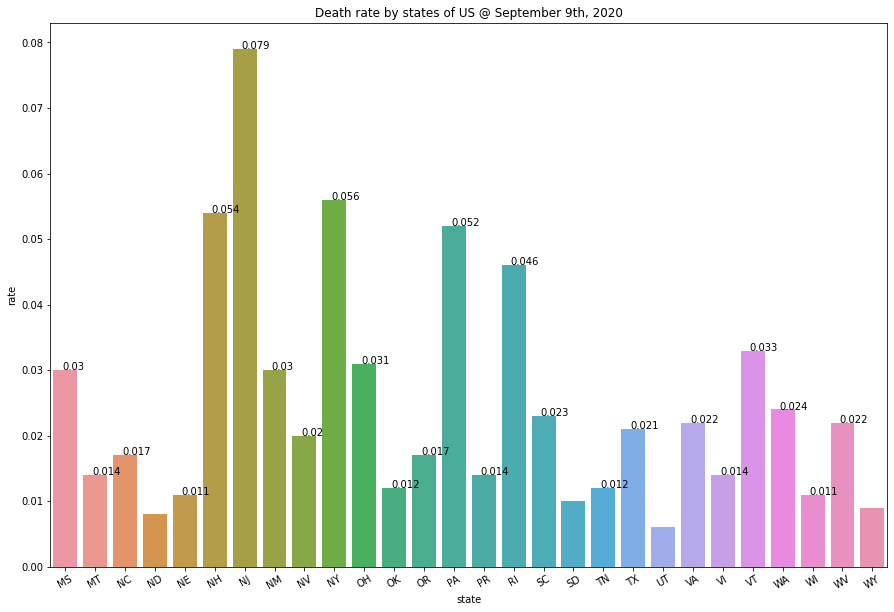

In [30]:
plt.figure(figsize=(15, 10))
plt.xticks(rotation=30)
g = sns.barplot(data=second_death_rate, x="state", y="rate")
for i, cnt in enumerate(second_death_rate["rate"]):
    if cnt > 0.01:
        g.text(x=i-0.1, y=cnt, s=cnt)

plt.title("Death rate by states of US @ September 9th, 2020")

Although California, Taxas, and Florida had top number of COVID-19 positive cases, we see that three states with top death rates are Connecticut, New Jersey, and Massachusett. This could be due to the different COVID-19 policies and how COVID-19 prevention is done. 

Data below visualize the cumulative number of deaths in these three states

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

Text(0.5, 1.0, 'Trend of death rates of top 3 states')

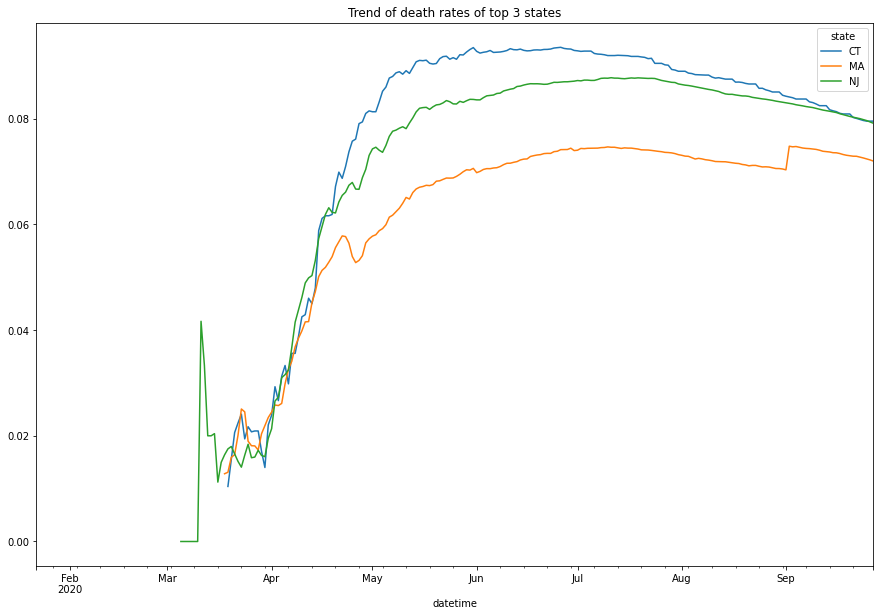

In [31]:
top_3_death = data_usa_state[data_usa_state['state'].isin(['NJ','MA','CT'])]

## rate = (num death)/(num positive + num death)
top_3_death['rate'] = top_3_death['death']/top_3_death['positive']

top_3_death['datetime'] = top_3_death['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

top_3_death.datetime = pd.to_datetime(top_3_death.datetime)

death_top_3 = top_3_death[['datetime','rate','state']]

death_top_3 = death_top_3.pivot(index = 'datetime', columns = 'state', values = 'rate')

death_top_3.plot(figsize=(15,10))

plt.title("Trend of death rates of top 3 states")

Note that death rate is the total number of death divide by the number of total cases. This means that as total number of death and total number of cases increase in different ratio, it is usual to see the fluctuation in the plot.

According to the death rate plot, we see that the first death found in New Jersey was around March 10th, 2020, while other two states hace first death in about 5 days after the first death was caught in New Jersey.

The death rates in these three states increase dramatically from early April to late April, and is in decreasing trend from July, 2020.